In [1]:
from PIL import Image, ImageDraw, ImageOps, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import make_interp_spline
from matplotlib import colors
import os
import io

In [117]:
source = Image.open('input/frog.png')
# source = Image.open('input/moscow.jpg')
secret = Image.open('input/field.jpg')

In [118]:
source_ratio = source.size[0] / source.size[1]
secret_ratio = secret.size[0] / secret.size[1]

if secret_ratio > source_ratio:
    secret = secret.resize((int(source.size[1] * secret_ratio),
                           source.size[1]))
    crop_x = round(secret.size[0] / 2 - source.size[0] / 2)
    secret = secret.crop((crop_x, 
                          0, 
                          crop_x + source.size[0], 
                          secret.size[1]))
else:
    secret = secret.resize((source.size[0], 
                            int(source.size[0] / secret_ratio)))
    crop_y = round(secret.size[1] / 2 - source.size[1] / 2)
    secret = secret.crop((0,
                          crop_y, 
                          secret.size[0], 
                          crop_y + source.size[1]))

In [69]:
# (1080, 1080, 3)

In [74]:
source_np.shape

(1600, 2560, 3)

In [100]:
%%time

source_np = np.array(source)[:,:,:3]
secret_np = np.array(secret)[:,:,:3]

gs = np.array([0.2126, 0.7152, 0.0722])
gs = np.array([0.299, 0.587, 0.114])

for i in range(source_np.shape[0]):
    for j in range(source_np.shape[1]):
        # target = (secret_np[i][j] / 255) @ gs
        target = 0.5
        old_rgb = source_np[i][j] / 255
        delta = gs * (gs @ old_rgb - target) / (gs @ gs)
        new_rgb = old_rgb - delta
        new_rgb = np.clip(new_rgb, 0, 1)
        source_np[i][j] = new_rgb * 255

CPU times: user 17.5 s, sys: 145 ms, total: 17.7 s
Wall time: 18.3 s


In [202]:
source_np = np.array(source)[:,:,:3]
secret_np = np.array(secret)[:,:,:3]

h, w, *_ = source_np.shape

gs = np.array([0.2126, 0.7152, 0.0722])
# gs = np.array([0.299, 0.587, 0.114])

target = 0.5
# target = (secret_np / 255) @ gs

old_rgb = source_np / 255
delta = gs * np.expand_dims(old_rgb @ gs - target, -1) / (gs @ gs)
new_rgb = old_rgb - delta
new_rgb = np.clip(new_rgb, 0, 1) * 255
source_np = new_rgb.astype('uint8')

In [207]:
a = np.random.uniform(size=(3, 1)).T
b = np.random.uniform(size=(3, 1))
(a @ b).shape

(1, 1)

In [213]:
%%time

# gs = [0.2126, 0.7152, 0.0722]
gs = [0.299, 0.587, 0.114]

source_np = np.array(source)[..., :3] / 255
secret_np = np.array(secret)[..., :3] / 255

h, w, _ = source_np.shape

gs = np.reshape(gs, (1, 3))

t = 0.5
# t = secret_np.reshape((h, w, 1, 3)) @ gs.T

colors = source_np.reshape((h, w, 1, 3))
bcs = -gs * (colors @ gs.T - t) / (gs @ gs.T)

ks = np.zeros((h, w, 6, 3))
ks[...] = (np.eye(6, k=-1) + np.eye(6))[..., ::2]

_tmp = np.reshape([0, 1] * 3, (3, 2))
alphas = _tmp - np.moveaxis(colors, -1, -2)
alphas = alphas.reshape((h, w, 6, 1))

# matrices = np.zeros((h, w, 3, 3))
# matrices[..., 0, 0] = colors[..., 0, 1] ** 2 + colors[..., 0, 2] ** 2
# matrices[..., 1, 1] = colors[..., 0, 0] ** 2 + colors[..., 0, 2] ** 2
# matrices[..., 2, 2] = colors[..., 0, 0] ** 2 + colors[..., 0, 1] ** 2
# matrices[..., 0, 1] = matrices[..., 1, 0] = -colors[..., 0, 0] * colors[..., 0, 1]
# matrices[..., 0, 2] = matrices[..., 2, 0] = -colors[..., 0, 0] * colors[..., 0, 2]
# matrices[..., 1, 2] = matrices[..., 2, 1] = -colors[..., 0, 1] * colors[..., 0, 2]

matrix = np.zeros((3, 3))
matrix[0, 0] = gs[0, 1] ** 2 + gs[0, 2] ** 2
matrix[1, 1] = gs[0, 0] ** 2 + gs[0, 2] ** 2
matrix[2, 2] = gs[0, 0] ** 2 + gs[0, 1] ** 2
matrix[0, 1] = matrix[1, 0] = -gs[0, 0] * gs[0, 1]
matrix[0, 2] = matrix[2, 0] = -gs[0, 0] * gs[0, 2]
matrix[1, 2] = matrix[2, 1] = -gs[0, 1] * gs[0, 2]

ms = (ks * alphas) @ matrix

ks = ks.reshape((h, w, 6, 1, 3))
ms = ms.reshape((h, w, 6, 3, 1))
bcs = bcs.reshape((h, w, 1, 3, 1))
alphas = alphas.reshape((h, w, 6, 1, 1))

bbcs = ms * (alphas - ks @ bcs) / (ks @ ms) + bcs
bbcs = bbcs.reshape((h, w, 6, 3))
bbcs = np.nan_to_num(bbcs, nan=2)

_ds = np.sum(bbcs ** 2, axis=-1)
_min_ds = np.min(_ds, axis=-1)[..., None]
bbcs = (_min_ds == _ds)[..., None] * bbcs
bbcs = bbcs.sum(axis=-2)

colors = colors.reshape((h, w, 3))
bcs = bcs.reshape((h, w, 3))

nc1 = np.round((colors + bcs) * 255)
nc2 = np.round((colors + bbcs) * 255)

_l_lim = np.any(nc1 < 0, axis=-1)
_r_lim = np.any(nc1 > 255, axis=-1)
_condition = (_l_lim | _r_lim)[..., None].repeat(3, -1)
nc = np.where(_condition, nc2, nc1).astype('uint8')

# Image.fromarray((np.clip(color + bc, 0, 1) * 255).reshape((h, w, 3)).astype('uint8')).convert('L')

<timed exec>:47: RuntimeWarning: invalid value encountered in divide


CPU times: user 1.87 s, sys: 844 ms, total: 2.72 s
Wall time: 3.59 s


In [212]:
y, x, step = 205, 540, 4
test_colors = colors[y:y+step, x:x+step]
test_bcs = bcs[y:y+step, x:x+step]
test_bbcs = bbcs[y:y+step, x:x+step]
# test_colors = colors[:3, :3]
# test_bcs = bcs[:3, :3]
nc1 = np.round((test_colors + test_bcs) * 255)#.astype('uint8')
nc2 = np.round((test_colors + test_bbcs) * 255)#.astype('uint8')

_l_lim = np.any(nc1 < 0, axis=-1)
_r_lim = np.any(nc1 > 255, axis=-1)
np.where((_l_lim | _r_lim)[..., None].repeat(3, -1), nc2, nc1)

array([[[146., 139.,  19.],
        [145., 140.,  19.],
        [146., 139.,  19.],
        [146., 139.,  19.]],

       [[150., 139.,   7.],
        [148., 141.,   6.],
        [150., 140.,   6.],
        [150., 140.,   6.]],

       [[151., 140.,   0.],
        [151., 140.,   0.],
        [152., 140.,   0.],
        [152., 140.,  -0.]],

       [[155., 138.,   0.],
        [153., 139.,   0.],
        [153., 139.,   0.],
        [153., 139.,   0.]]])

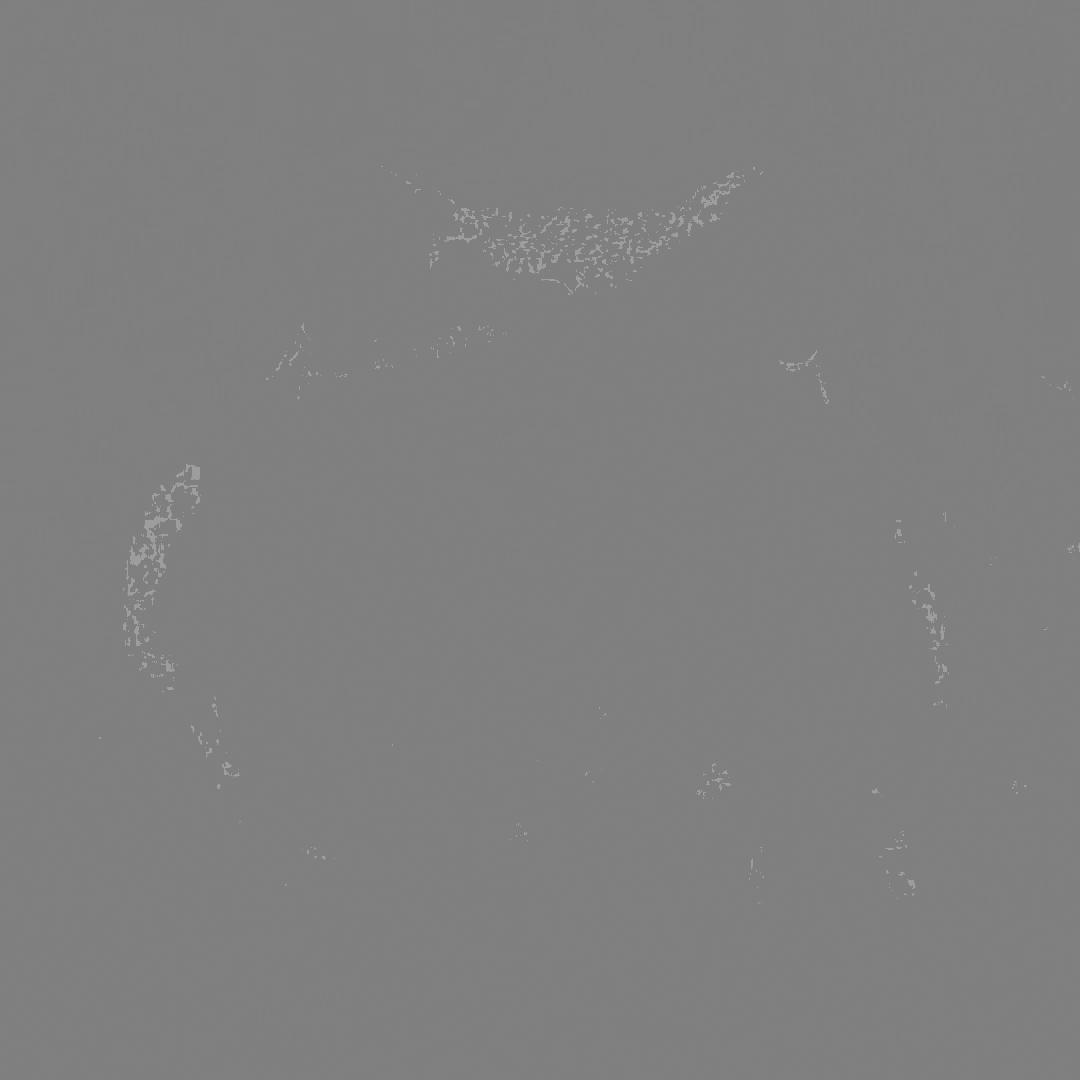

In [218]:
Image.fromarray(nc).convert('L')

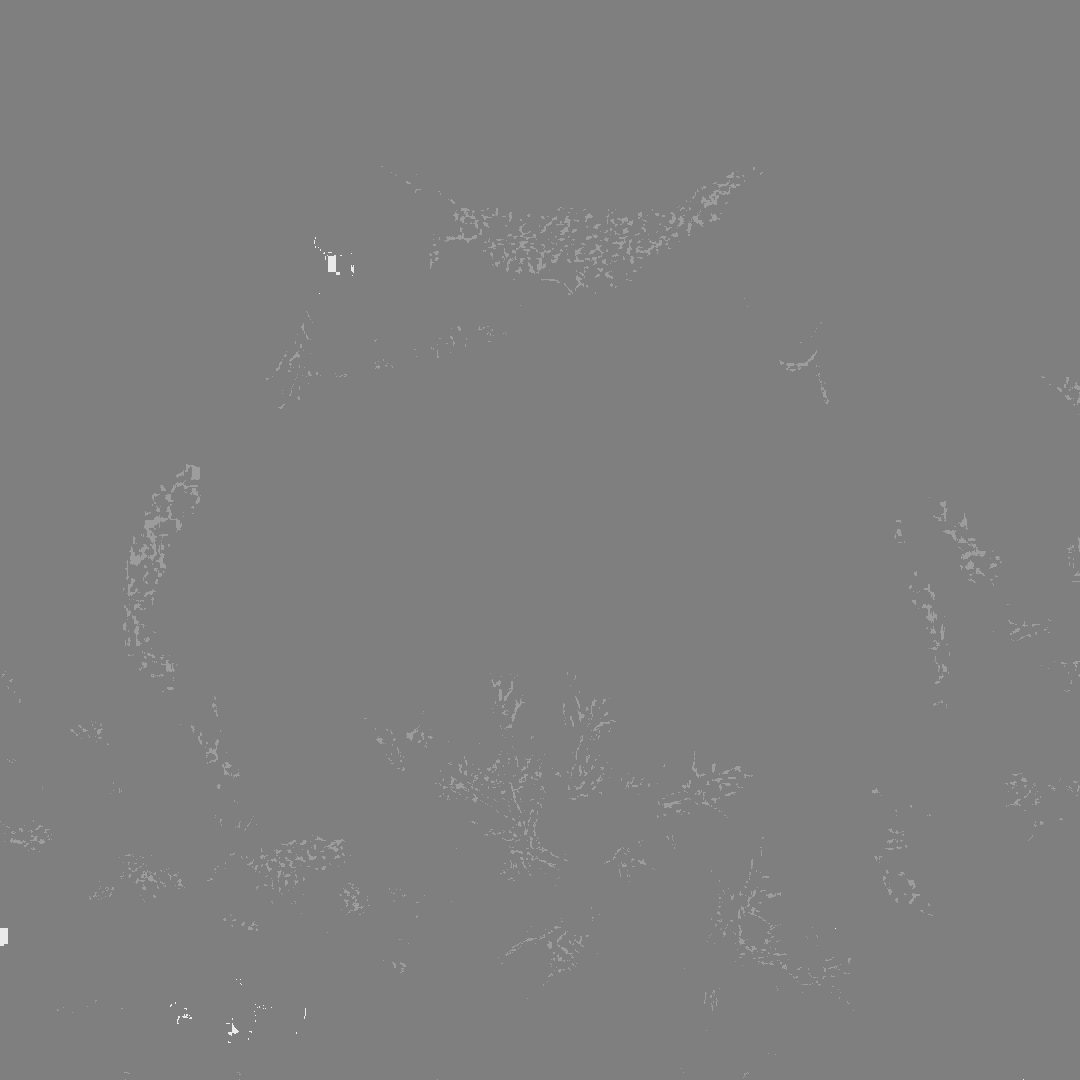

In [221]:
Image.fromarray(((colors + bbcs) * 255).astype('uint8')).convert('L')

In [374]:
print('    ms:', ms.shape)
print('alphas:', alphas.shape)
print('    ks:', ks.shape)
print('   bcs:', bcs.shape)

    ms: (1080, 1080, 6, 3, 1)
alphas: (1080, 1080, 6, 1, 1)
    ks: (1080, 1080, 6, 1, 3)
   bcs: (1080, 1080, 1, 3, 1)


In [127]:
i, j = 0, 0

color = colors[i, j].flatten()
k = ks[i, j].reshape(6, 1, 3)
m = ms[i, j].reshape(6, 3, 1)
alpha = alphas[i, j].reshape(6, 1, 1)
bc = bcs[i, j].reshape(3, 1)

dots = (m * (alpha - k @ bc) / (k @ m) + bc).reshape(6, 3)

print('color:', color), print()
print('matrix:\n', matrix, '\n', sep='')
print('k:\n', k.reshape(6, 3), '\n', sep='')
print('m:\n', m.reshape(6, 3), '\n', sep='')
print('alpha:\n', alpha.reshape(6), '\n', sep='')
print('bc:\n', bc.reshape(3), '\n', sep='')
print('dots:\n', dots, '\n', sep='')

# (color + bc) @ gs.flatten()

color: [0.06666667 0.07843137 0.        ]

matrix:
[[ 0.357565 -0.175513 -0.034086]
 [-0.175513  0.102397 -0.066918]
 [-0.034086 -0.066918  0.43397 ]]

k:
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]

m:
[[-0.02383767  0.01170087  0.0022724 ]
 [ 0.33372733 -0.16381213 -0.0318136 ]
 [ 0.01376573 -0.00803114  0.00524847]
 [-0.16174727  0.09436586 -0.06166953]
 [ 0.          0.          0.        ]
 [-0.034086   -0.066918    0.43397   ]]

alpha:
[-0.06666667  0.93333333 -0.07843137  0.92156863  0.          1.        ]

bc:
[0.2903447  0.57000782 0.11069998]

dots:
[[-0.06666667  0.74524906  0.14473321]
 [ 0.93333333  0.25439285  0.04940509]
 [ 1.40179823 -0.07843137  0.53446488]
 [-0.31224613  0.92156863 -0.11905036]
 [        nan         nan         nan]
 [ 0.22049498  0.43287811  1.        ]]



/var/folders/5d/m60s_l4s0rxgzhtn791xykqr0000gn/T/ipykernel_58315/421630910.py:9: RuntimeWarning: invalid value encountered in divide
  dots = (m * (alpha - k @ bc) / (k @ m) + bc).reshape(6, 3)


In [124]:
def get_borders(color):
    r, g, b = color
    return np.array(
        [[ -r,   0,   0], 
         [1-r,   0,   0],
         [  0,  -g,   0],
         [  0, 1-g,   0],
         [  0,   0,  -b],
         [  0,   0, 1-b]]
    )

def get_matrix(grayscale):
    r, g, b = grayscale
    return np.array(
        [[g*g+b*b,    -r*g,    -r*b], 
         [   -r*g, r*r+b*b,    -g*b], 
         [   -r*b,    -g*b, r*r+g*g]]
    )

# color = np.array([0.1, 0.9, 0.1])
# gs = np.array([0.2, 0.3, 0.5])
color = np.array([0.06666667, 0.07843137, 0.0])
gs = np.array([0.299, 0.587, 0.114])
target = 0.5

borders = get_borders(color)
alphas = np.sum(borders, axis=-1)
ks = borders.astype(bool).astype(int)
matrix = get_matrix(gs)
ms = borders @ matrix
bc = -gs * (gs @ color - target) / (gs @ gs)
dots = ms * np.expand_dims(alphas - ks @ bc, -1) / (np.expand_dims(ks, -2) @ np.expand_dims(ms, -1)).reshape((6, 1)) + bc

print('color:', color), print()
print('matrix:\n', matrix, '\n', sep='')
print('k:\n', ks, '\n', sep='')
print('m:\n', ms, '\n', sep='')
print('alpha:\n', alphas, '\n', sep='')
print('bc:\n', bc, '\n', sep='')
print('dots:\n', dots, '\n', sep='')

color: [0.06666667 0.07843137 0.        ]

matrix:
[[ 0.357565 -0.175513 -0.034086]
 [-0.175513  0.102397 -0.066918]
 [-0.034086 -0.066918  0.43397 ]]

k:
[[1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 0 0]
 [0 0 1]]

m:
[[-0.02383767  0.01170087  0.0022724 ]
 [ 0.33372733 -0.16381213 -0.0318136 ]
 [ 0.01376573 -0.00803114  0.00524847]
 [-0.16174727  0.09436586 -0.06166953]
 [ 0.          0.          0.        ]
 [-0.034086   -0.066918    0.43397   ]]

alpha:
[-0.06666667  0.93333333 -0.07843137  0.92156863  0.          1.        ]

bc:
[0.2903447  0.57000782 0.11069998]

dots:
[[-0.06666667  0.74524906  0.14473321]
 [ 0.93333333  0.25439286  0.04940509]
 [ 1.40179823 -0.07843137  0.53446488]
 [-0.31224613  0.92156863 -0.11905036]
 [        nan         nan         nan]
 [ 0.22049498  0.43287811  1.        ]]



/var/folders/5d/m60s_l4s0rxgzhtn791xykqr0000gn/T/ipykernel_58315/3865206412.py:32: RuntimeWarning: invalid value encountered in divide
  dots = ms * np.expand_dims(alphas - ks @ bc, -1) / (np.expand_dims(ks, -2) @ np.expand_dims(ms, -1)).reshape((6, 1)) + bc


In [197]:
np.sum(dots ** 2, axis=-1)

array([0.43470588, 0.90529412, 2.17862069, 0.38551724, 1.30307692,
       0.87230769])

In [155]:
r, g, b = 0.2, 0.3, 0.5
np.dot([0, 0.1, 0], [[g*g+b*b, -r*g, -r*b], [-r*g, r*r+b*b, -g*b], [-r*b, -g*b, r*r+g*g]])

array([-0.006,  0.029, -0.015])